# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [538]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_proj2_starter_code/cs445_proj2_starter_code-2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .



In [539]:
import utils
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [540]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    import random

    output_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    num_patches = (out_size//patch_size)
    for i in range(num_patches):
      for x in range(num_patches):
        row = random.randint(0, 192-patch_size)
        column = random.randint(0, 192-patch_size)
        patch = sample[row:row+patch_size, column:column+patch_size, :]
        output_img[i*patch_size:(i+1)*patch_size, x*patch_size:(x+1)*patch_size, :] = patch

    return output_img





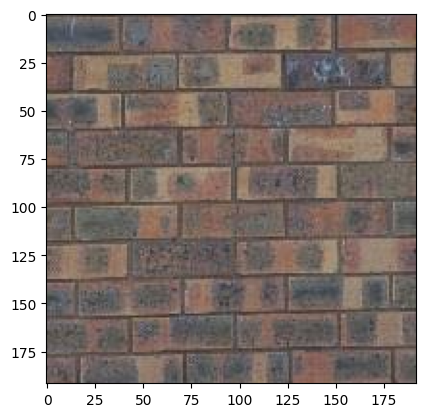

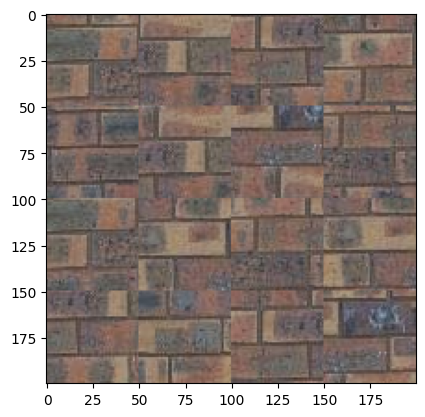

In [541]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 50
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [542]:
import random

def ssd_patch(T,M,I):
    # Ensure float calculations
    T = T.astype(np.float64)
    M = M.astype(np.float64)
    I = I.astype(np.float64)

    # Patch size
    patch_h, patch_w = T.shape[:2]
    img_h, img_w = I.shape[:2]

    # Initialize SSD cost matrix
    ssd_cost = np.full((img_h - patch_h + 1, img_w - patch_w + 1), np.inf)

    # Compute SSD for each possible patch in I
    for y in range(img_h - patch_h + 1):
        for x in range(img_w - patch_w + 1):
            I_patch = I[y:y + patch_h, x:x + patch_w]

            # Compute SSD only over the masked region
            diff = (I_patch - T) * M  # Apply mask
            ssd_cost[y, x] = np.sum(diff ** 2)

    return ssd_cost

def choose_sample(I, ssd_cost, patch_size, tol):

    # Get top tol indices
    top_indices = np.argsort(ssd_cost.flatten())[:tol]  # Sort by lowest SSD

    # Choose a random index from the best `tol` patches
    random_patch_idx = random.choice(top_indices)

    # Convert flattened index to 2D coordinates
    y, x = np.unravel_index(random_patch_idx, ssd_cost.shape)

    # Ensure patch does not exceed bounds
    y = min(y, I.shape[0] - patch_size)
    x = min(x, I.shape[1] - patch_size)

    # Extract the selected patch
    patch = I[y:y + patch_size, x:x + patch_size]

    return patch

In [543]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    import random

    #create output of appropriate size as 0 array
    output_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    #calculate how many patches we will need across each row/column
    num_patches = (out_size-overlap)//(patch_size-overlap)

    #setting first patch as top left of image for testing
    random_row = np.random.randint(0, sample.shape[0] - patch_size)
    random_column = np.random.randint(0, sample.shape[1] - patch_size)
    first_patch = sample[random_row:random_row + patch_size, random_column:random_column + patch_size]
    output_img[0:patch_size, 0:patch_size] = first_patch

    #iterate over rows
    for i in range(num_patches):
      #iterate over columns
      for x in range(num_patches):
        if i==0 and x==0:
          continue

        bottom_row = (i*(patch_size-overlap) + patch_size)
        right_column = (x*(patch_size-overlap) + patch_size)

        #copy template of area to be patched
        template = output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :]


        #Create mask for overlapping region
        mask = np.zeros(template.shape, dtype=np.uint8)
        if i == 0:
          mask[:,overlap::-1,:] = 255
        elif x==0:
          mask[overlap::-1,:,:]  = 255
        else:
          mask[overlap::-1,:,:]  = 255
          mask[:,overlap::-1,:] = 255


        #ssd_patch method
        ssd_cost = ssd_patch(template, mask, sample)

        #choose_sample method
        low_cost_patch =  choose_sample(sample, ssd_cost, patch_size, tol)

        #apply randomly selected low cost sample
        output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :] = low_cost_patch



    return output_img



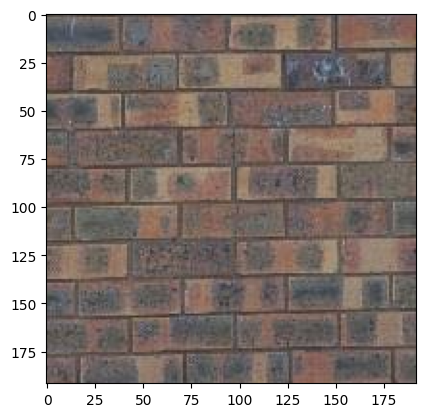

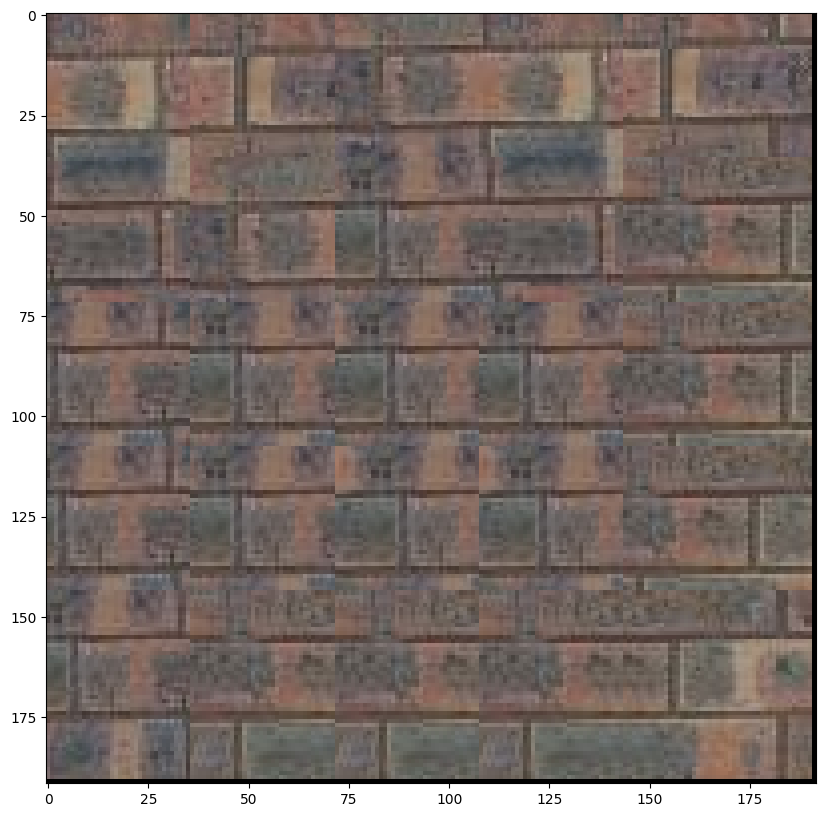

In [544]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 192  # change these parameters as needed
patch_size = 47
overlap =  11
tol = 2
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [545]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass


import numpy as np

def cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch

    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """

    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]

    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]

    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask

In [546]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """

    import random

    #create output of appropriate size as 0 array
    output_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)


    out_size_row = sample.shape[0]
    out_size_col = sample.shape[1]


    #calculate how many patches we will need across each row/column
    num_row_patches = (out_size_row-overlap)//(patch_size-overlap)
    num_col_patches = (out_size_col-overlap)//(patch_size-overlap)


    #calculate how many patches we will need across each row/column
    num_patches = (out_size-overlap)//(patch_size-overlap)

    #setting first patch as top left of image for testing
    random_row = np.random.randint(0, sample.shape[0] - patch_size)
    random_column = np.random.randint(0, sample.shape[1] - patch_size)
    first_patch = sample[random_row:random_row + patch_size, random_column:random_column + patch_size]
    output_img[0:patch_size, 0:patch_size] = first_patch

    # print(new_overlap_vert.shape)
    plt.imshow(first_patch, cmap="gray")
    plt.show()

    #iterate over rows
    for i in range(num_patches):
      #iterate over columns
      for x in range(num_patches):
        if i==0 and x==0:
          continue

        bottom_row = (i*(patch_size-overlap) + patch_size)
        right_column = (x*(patch_size-overlap) + patch_size)

        #copy template of area to be patched
        template = output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :]

        # print(i,x)
        # plt.imshow(template)
        # plt.title(f"template at i={i}, x={x}")
        # plt.show()



        #Create mask for overlapping region
        mask = np.zeros(template.shape, dtype=np.uint8)

        if i == 0:
          mask[:,:overlap,:] = 255
        elif x==0:
          mask[:overlap,:,:]  = 255
        else:
          mask[:overlap,:,:]  = 255
          mask[:,:overlap,:] = 255

        # Apply the mask to the template


        old_overlap_vert = np.zeros(template.shape, dtype=np.uint8)
        old_overlap_hor = np.zeros(template.shape, dtype=np.uint8)

        old_overlap_vert[:,:overlap,:] = template[:,:overlap,:] if x>0 else 0
        old_overlap_hor[:overlap,:,:] = template[:overlap,:,:] if i>0 else 0


        # old_overlap_vert = template[:,:overlap,:] if x>0 else 0
        # old_overlap_hor = template[:overlap,:,:] if i>0 else 0


        # print(i,x)
        # plt.imshow(old_overlap_vert, cmap="gray")
        # plt.title(f"old_overlap_vert at i={i}, x={x}")
        # plt.show()

        # print(i,x)
        # plt.imshow(old_overlap_hor, cmap="gray")
        # plt.title(f"old_overlap_hor at i={i}, x={x}")
        # plt.show()


        #ssd_patch method
        ssd_cost = ssd_patch(template, mask, sample)

        # (b) Pixelwise SSD cost visualization
        # plt.imshow(ssd_cost, cmap='hot')  # Visualize SSD cost using 'hot' colormap
        # plt.title('Pixelwise SSD Cost')
        # plt.axis('off')  # Turn off axis
        # plt.show()


        #choose_sample method
        low_cost_patch =  choose_sample(sample, ssd_cost, patch_size, tol)


        new_overlap_vert = np.zeros(low_cost_patch.shape, dtype=np.uint8)
        new_overlap_hor = np.zeros(low_cost_patch.shape, dtype=np.uint8)

        new_overlap_hor[:overlap,:,:] = low_cost_patch[:overlap,:,:] if i> 0 else 0
        new_overlap_vert[:,:overlap,:] = low_cost_patch[:,:overlap,:] if x>0 else 0

        # plt.imshow(old_overlap_vert, cmap="gray")
        # plt.title(f"old_overlap_vert at i={i}, x={x}")
        # plt.show()
        # print(old_overlap_vert.shape)

        # plt.imshow(old_overlap_hor, cmap="gray")
        # plt.title(f"old_overlap_hor at i={i}, x={x}")
        # plt.show()

        # print(i,x)
        # plt.imshow(low_cost_patch, cmap="gray")
        # plt.title(f"low_cost_patch at i={i}, x={x}")
        # plt.show()

        # plt.imshow(new_overlap_vert, cmap="gray")
        # plt.title(f"new_overlap_vert at i={i}, x={x}")
        # plt.show()
        # print(new_overlap_vert.shape)

        # plt.imshow(new_overlap_hor, cmap="gray")
        # plt.title(f"new_overlap_hor at i={i}, x={x}")
        # plt.show()


        # new_overlap_hor = low_cost_patch[:overlap,:,:] if i> 0 else 0
        # new_overlap_vert = low_cost_patch[:,:overlap,:] if x>0 else 0







        bndcost_hor = np.sum(((old_overlap_hor[:overlap, :, :] - new_overlap_hor[:overlap, :, :]) ** 2), axis=-1).astype(float)

        bndcost_vert = np.sum(((old_overlap_vert[:, :overlap, :] - new_overlap_vert[:, :overlap, :]) ** 2), axis=-1).astype(float)




        vert_seam = cut(bndcost_vert.T)
        vert_seam = vert_seam.T
        hor_seam = cut(bndcost_hor)
        # hor_seam = hor_seam.T

        target_shape = (max(vert_seam.shape[0], hor_seam.shape[0]), max(vert_seam.shape[1], hor_seam.shape[1]))
        vert_seam_padded = np.pad(vert_seam,
                                    ((0, target_shape[0] - vert_seam.shape[0]),  # Pad bottom
                                      (0, target_shape[1] - vert_seam.shape[1])),  # Pad right
                                    constant_values=1)  # Padding value = 1 (white)


        hor_seam_padded = np.pad(hor_seam,
                                  ((0, target_shape[0] - hor_seam.shape[0]),  # Pad bottom
                                    (0, target_shape[1] - hor_seam.shape[1])),  # Pad right
                                  constant_values=1)  # Padding value = 1 (white)



        # # print(new_overlap_vert.shape)
        # plt.imshow(vert_seam, cmap="gray")
        # plt.title(f"vert_seam at i={i}, x={x}")
        # plt.show()

        # # print(new_overlap_hor.shape)
        # plt.imshow(hor_seam, cmap="gray")
        # plt.title(f"hor_seam at i={i}, x={x}")
        # plt.show()


        # # print(new_overlap_vert.shape)
        # plt.imshow(vert_seam_padded, cmap="gray")
        # plt.title(f"vert_seam_padded at i={i}, x={x}")
        # plt.show()


        # # print(new_overlap_hor.shape)
        # plt.imshow(hor_seam_padded, cmap="gray")
        # plt.title(f"hor_seam_padded at i={i}, x={x}")
        # plt.show()

        # mask = (np.logical_and(vert_seam,hor_seam))
        mask = np.logical_and(vert_seam_padded, hor_seam_padded)
        mask = np.expand_dims(mask, axis=-1)  # Shape becomes (47, 47, 1)
        mask = np.repeat(mask, 3, axis=-1)  # Shape becomes (47, 47, 3)
        cut_patch = mask*low_cost_patch



        # Convert the mask to a valid displayable format
        mask_display = (mask * 255).astype(np.uint8)
        # mask = mask.astype(np.uint8)


        # print(i,x)
        # plt.imshow(mask_display, cmap="gray")
        # plt.title(f"combined mask at i={i}, x={x}")
        # plt.show()


        output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :] = output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :] * (1-mask)


        #apply randomly selected low cost sample
        output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :] = output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, :] + cut_patch
      # if i==1: break


    return output_img


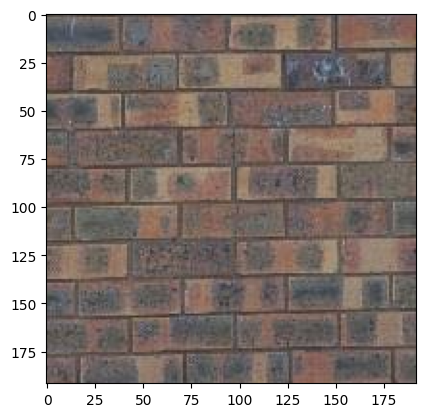

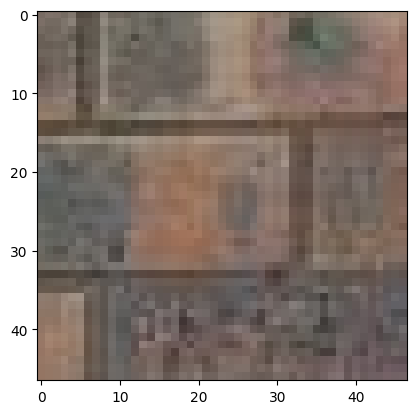

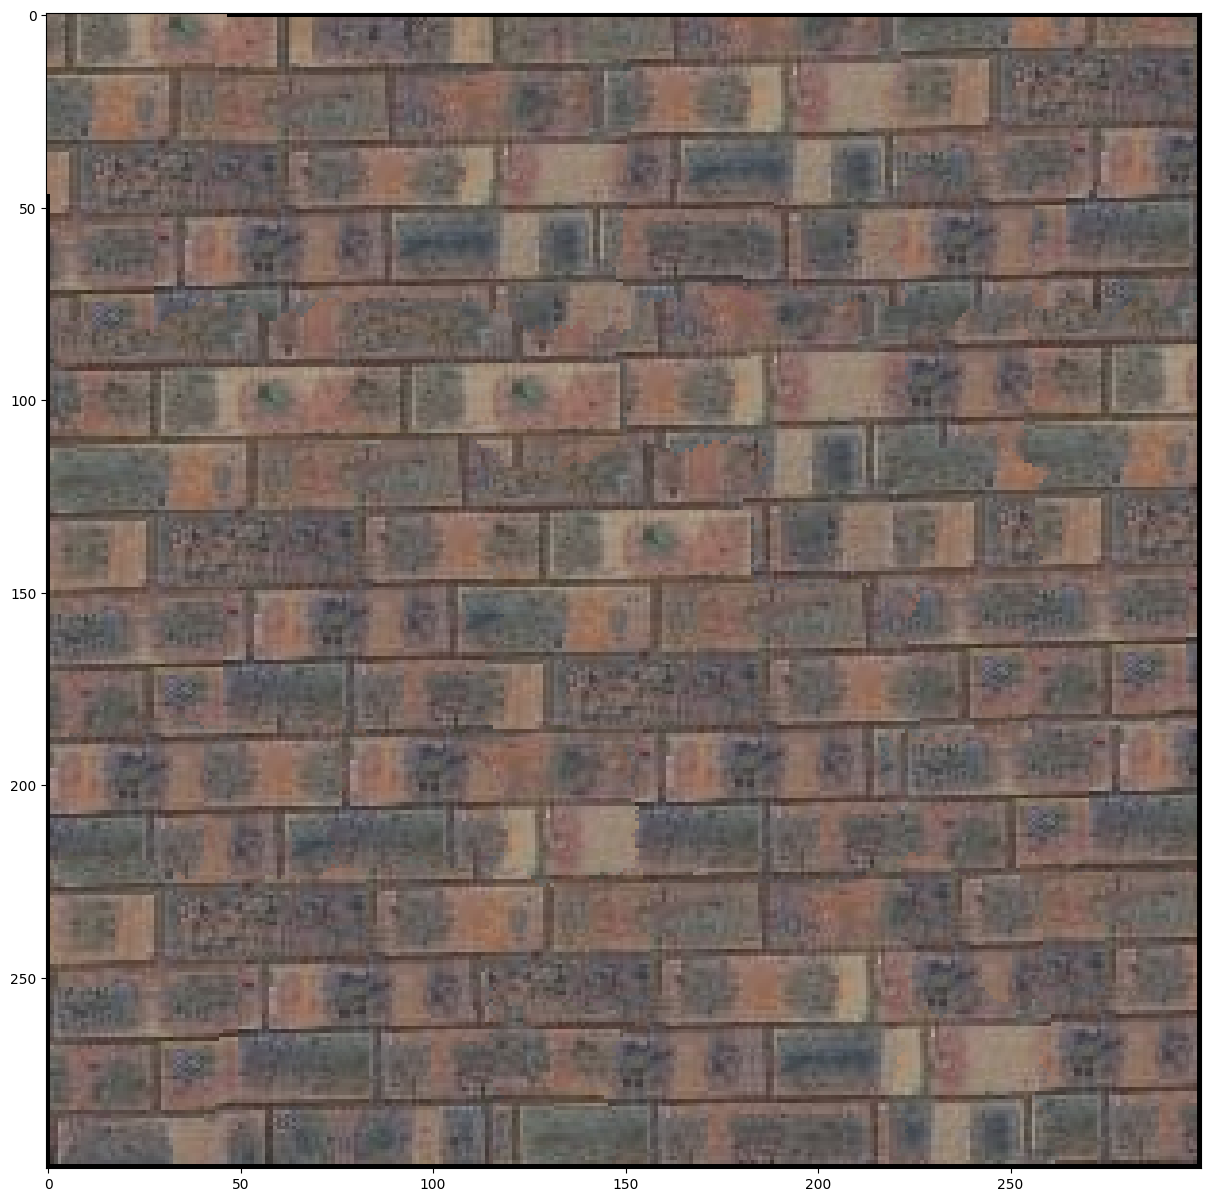

In [547]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 47
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

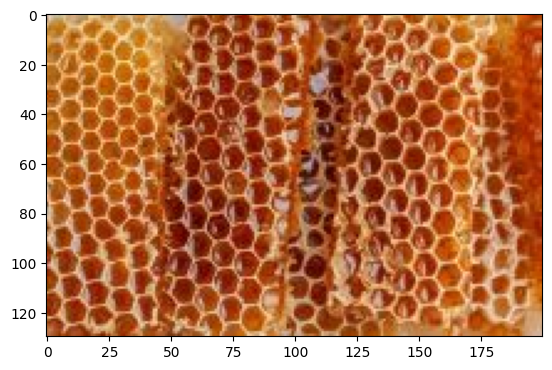

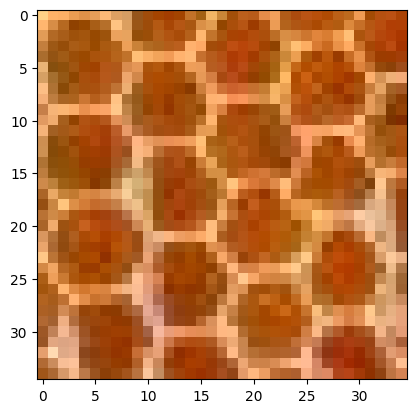

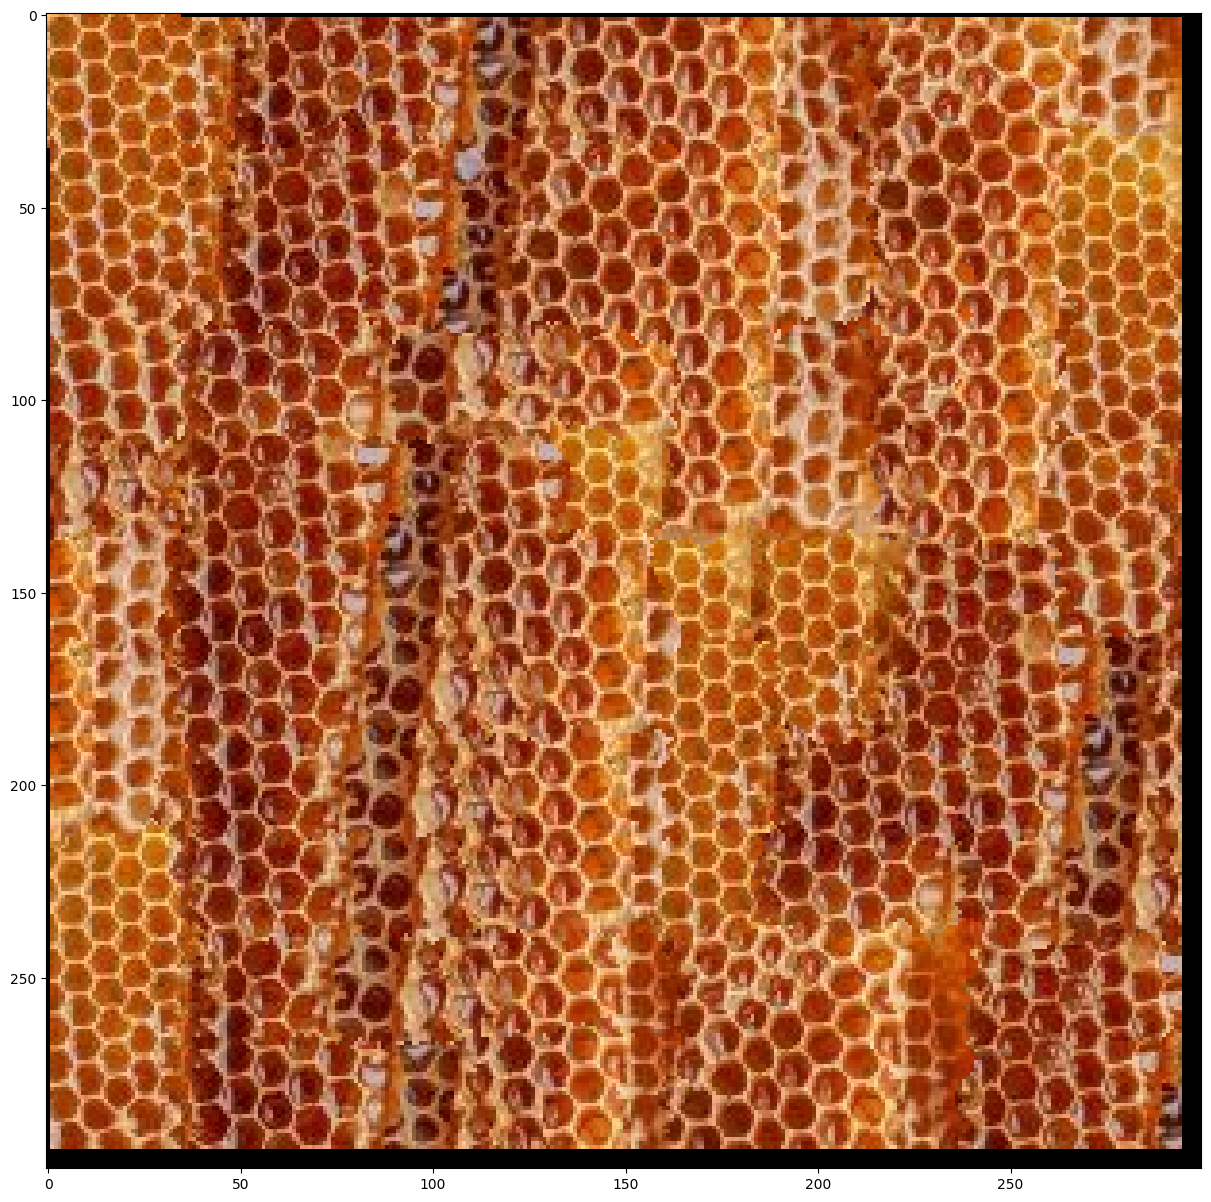

In [549]:
sample_img_fn = datadir + 'honeycomb2.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 35
overlap = 9
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

In [550]:
sample_img_fn = datadir + 'sand2.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 600  # change these parameters as needed
patch_size = 79
overlap = 12
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

Output hidden; open in https://colab.research.google.com to view.

### part IV: Texture Transfer (30 pts)

In [551]:
def choose_texture_sample(I, ssd_overlap, ssd_transfer, patch_size, tol, alpha, A_texture=None, B_texture=None):

    ssd_overlap = ssd_overlap.astype(np.float64)
    ssd_transfer = ssd_transfer.astype(np.float64)
    alpha = float(alpha)



    # Compute combined cost: alpha * ssd_overlap + (1-alpha) * ssd_transfer
    combined_cost = alpha * ssd_overlap + (1.0 - alpha) * ssd_transfer

    # Get top tol indices from the combined cost
    top_indices = np.argsort(combined_cost.flatten())[:tol]  # Sort by lowest combined cost

    # Choose a random index from the best `tol` patches
    random_patch_idx = random.choice(top_indices)

    # Convert flattened index to 2D coordinates
    y, x = np.unravel_index(random_patch_idx, combined_cost.shape)

    # Ensure patch does not exceed bounds
    y = min(y, I.shape[0] - patch_size)
    x = min(x, I.shape[1] - patch_size)

    # Extract the selected patch from the luminance channel
    patch_L = I[y:y + patch_size, x:x + patch_size]

    # If A_texture and B_texture are provided (in Lab space), extract A and B channels
    if A_texture is not None and B_texture is not None:
        patch_A = A_texture[y:y + patch_size, x:x + patch_size]
        patch_B = B_texture[y:y + patch_size, x:x + patch_size]
        # Combine into a full patch in the Lab color space
        full_patch_lab = np.stack([patch_L, patch_A, patch_B], axis=-1)
        return full_patch_lab

    # If A_texture and B_texture are not provided, return just the L channel patch
    return patch_L


def ssd_patch(T,M,I):
    # Ensure float calculations
    T = T.astype(np.float64)
    M = M.astype(np.float64)
    I = I.astype(np.float64)

    # Patch size
    patch_h, patch_w = T.shape[:2]
    img_h, img_w = I.shape[:2]

    # Initialize SSD cost matrix
    ssd_cost = np.full((img_h - patch_h + 1, img_w - patch_w + 1), np.inf)

    # Compute SSD for each possible patch in I
    for y in range(img_h - patch_h + 1):
        for x in range(img_w - patch_w + 1):
            I_patch = I[y:y + patch_h, x:x + patch_w]

            # Compute SSD only over the masked region
            diff = (I_patch - T) * M  # Apply mask
            ssd_cost[y, x] = np.sum(diff ** 2)

    return ssd_cost


In [555]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """

    import random


    out_size_row = guidance_im.shape[0]
    out_size_col = guidance_im.shape[1]

    # Calculate new dimensions while keeping aspect ratio
    aspect_ratio = out_size_col / out_size_row # width/height ratio

    # Set the desired height (for example, scaling to match the height of the grass image)
    desired_height = sample.shape[0]

    # Calculate new width based on the aspect ratio
    desired_width = int(desired_height * aspect_ratio)

    # Resize Guidance image while maintaining aspect ratio
    guidance_im = cv2.resize(guidance_im, (desired_width, desired_height))

    sample = cv2.resize(sample, (desired_width, desired_height))

    # Create a 2x2 grid by repeating the resized image
    # top_row = np.hstack((sample, sample))  # Horizontally stack the resized images
    # bottom_row = np.hstack((sample, sample))  # Horizontally stack the resized images

    # # Stack the top and bottom rows vertically
    # sample = np.vstack((top_row, bottom_row))

    sample = cv2.resize(sample, (desired_width, desired_height))


    # Display resized image
    plt.imshow(guidance_im)
    plt.show()
    # Display resized image
    plt.imshow(sample)
    plt.show()


    out_size_row = guidance_im.shape[0]
    out_size_col = guidance_im.shape[1]

    print(guidance_im.shape[0])
    print(guidance_im.shape[1])

    print(sample.shape[0])
    print(sample.shape[1])

    #calculate how many patches we will need across each row/column
    num_row_patches = (out_size_row-overlap)//(patch_size-overlap)
    num_col_patches = (out_size_col-overlap)//(patch_size-overlap)

    print(num_row_patches)
    print(num_col_patches)

    #Convert images to gray
    texture_img = cv2.cvtColor(sample, cv2.COLOR_RGB2Lab)
    guidance_img = cv2.cvtColor(guidance_im, cv2.COLOR_RGB2Lab)

    #setting first patch as top left of image for testing
    random_row = np.random.randint(0, texture_img.shape[0] - patch_size)
    random_column = np.random.randint(0, texture_img.shape[1] - patch_size)
    first_patch = texture_img[random_row:random_row + patch_size, random_column:random_column + patch_size]



    first_patch_rgb = cv2.cvtColor(first_patch.astype(np.uint8), cv2.COLOR_LAB2RGB)

    # plt.imshow(first_patch_rgb)
    # plt.title("first_patch")
    # plt.show()


    print(texture_img.shape)  # Should be (height, width, 3)


    # Split channels
    L_guidance, _ , _ = cv2.split(guidance_img)
    L_texture, A_texture , B_texture = cv2.split(texture_img)

    # Blur Luminance Channels
    L_guidance = cv2.GaussianBlur(L_guidance, (5, 5), 0)
    L_texture = cv2.GaussianBlur(L_texture, (5, 5), 0)

    output_img = np.stack([L_guidance] * 3, axis=-1)

    output_img[0:patch_size, 0:patch_size] = first_patch



    #iterate over rows
    for i in range(num_row_patches):
      #iterate over columns
      for x in range(num_col_patches):
        if i==0 and x==0:
          continue

        bottom_row = (i*(patch_size-overlap) + patch_size)
        right_column = (x*(patch_size-overlap) + patch_size)

        # plt.imshow(output_img, cmap="gray")
        # plt.title(f"output_img at i={i}, x={x}")
        # plt.show()

        #copy template of area to be patched
        template = output_img[i*(patch_size-overlap):bottom_row, x*(patch_size-overlap):right_column, 0]

        #Create mask for overlapping region
        mask = np.zeros(template.shape, dtype=np.uint8)

        if i == 0:
          mask[:,:overlap] = 255
        elif x==0:
          mask[:overlap,:]  = 255
        else:
          mask[:overlap,:]  = 255
          mask[:,:overlap] = 255

        mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 or 1)
        mask = mask.astype(float)


        # Apply the mask to the template
        old_overlap_vert = np.zeros(template.shape, dtype=np.uint8)
        old_overlap_hor = np.zeros(template.shape, dtype=np.uint8)

        old_overlap_vert[:,:overlap] = template[:,:overlap] if x>0 else 0
        old_overlap_hor[:overlap,:] = template[:overlap,:] if i>0 else 0

        old_target = template - old_overlap_vert -old_overlap_hor

        #ssd_patch method

        # plt.imshow(template, cmap="gray")
        # plt.title(f"template at i={i}, x={x}")
        # plt.show()
        # print(old_overlap_vert.shape)

        # plt.imshow(mask, cmap="gray")
        # plt.title(f"mask at i={i}, x={x}")
        # plt.show()

        # plt.imshow(L_texture, cmap="gray")
        # plt.title(f"L_texture at i={i}, x={x}")
        # plt.show()

        mask_inverse = 1 - mask
        mask_inverse = mask_inverse.astype(float)

        # plt.imshow(mask_inverse, cmap="gray")
        # plt.title(f"mask_inverse")
        # plt.show()


        ssd_overlap = ssd_patch(template, mask, L_texture)

        ssd_transfer = ssd_patch(template, mask_inverse, L_texture)

        # ssd_overlap_padded, ssd_transfer_padded = pad_ssd_based_on_mask(ssd_overlap, ssd_transfer, mask, mask_inverse)

        # visualize_ssd_matrices(ssd_overlap, ssd_transfer, ssd_overlap_padded, ssd_transfer_padded)


        # # Making ssd costs same size for
        # # ssd_overlap_padded = np.pad(ssd_overlap, ((0, guidance_im.shape[0] - ssd_overlap.shape[0]),
        # #                                     (0, guidance_im.shape[1] - ssd_overlap.shape[1])), mode='constant')
        # # ssd_transfer_padded = np.pad(ssd_transfer, ((0, guidance_im.shape[0] - ssd_transfer.shape[0]),
        #                                   #  (0, guidance_im.shape[1] - ssd_transfer.shape[1])), mode='constant')

        # print(ssd_overlap.shape)
        # print(ssd_transfer.shape)


        #choose_sample method
        low_cost_patch = choose_texture_sample(L_texture, ssd_overlap, ssd_transfer, patch_size, tol, alpha, A_texture, B_texture)
        # Extract just the luminance (L) channel from low_cost_patch
        luminance_patch = low_cost_patch[..., 0]


        new_overlap_vert = np.zeros(luminance_patch.shape, dtype=np.uint8)
        new_overlap_hor = np.zeros(luminance_patch.shape, dtype=np.uint8)

        new_overlap_hor[:overlap,:] = luminance_patch[:overlap,:] if i> 0 else 0
        new_overlap_vert[:,:overlap] = luminance_patch[:,:overlap] if x>0 else 0


        bndcost_hor = ((old_overlap_hor[:overlap, :] - new_overlap_hor[:overlap, :]) ** 2).astype(float)

        bndcost_vert = ((old_overlap_vert[:, :overlap] - new_overlap_vert[:, :overlap]) ** 2).astype(float)

        # print(bndcost_hor.shape)
        # print(bndcost_vert.shape)


        vert_seam = cut(bndcost_vert.T)
        vert_seam = vert_seam.T
        hor_seam = cut(bndcost_hor)
        # hor_seam = hor_seam.T

        target_shape = (max(vert_seam.shape[0], hor_seam.shape[0]), max(vert_seam.shape[1], hor_seam.shape[1]))
        vert_seam_padded = np.pad(vert_seam,
                                    ((0, target_shape[0] - vert_seam.shape[0]),  # Pad bottom
                                      (0, target_shape[1] - vert_seam.shape[1])),  # Pad right
                                    constant_values=1)  # Padding value = 1 (white)

        hor_seam_padded = np.pad(hor_seam,
                                  ((0, target_shape[0] - hor_seam.shape[0]),  # Pad bottom
                                    (0, target_shape[1] - hor_seam.shape[1])),  # Pad right
                                  constant_values=1)  # Padding value = 1 (white)


        mask = np.logical_and(vert_seam_padded, hor_seam_padded)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype(float)


        cut_patch = mask * low_cost_patch + (1 - mask) *0 # Neutral Lab value for A/B



        cut_patch_rgb = cv2.cvtColor(cut_patch.astype(np.uint8), cv2.COLOR_LAB2RGB)

        # plt.imshow(cut_patch_rgb)
        # plt.title(f"cut_patch at i={i}, x={x}")
        # plt.show()

        mask_inverse = 1 - mask
        mask_inverse = mask_inverse.astype(float)


        patch  = output_img[i * (patch_size - overlap):bottom_row, x * (patch_size - overlap):right_column]


        cut_overlap_patch = mask_inverse * patch + (1 - mask_inverse) * 0

        cut_overlap_patch_rgb = cv2.cvtColor(cut_overlap_patch.astype(np.uint8), cv2.COLOR_LAB2RGB)

        # plt.imshow(cut_overlap_patch_rgb)
        # plt.title("Kept_overlap")
        # plt.show()


        patch = cut_patch + cut_overlap_patch


        output_img[i * (patch_size - overlap):bottom_row, x * (patch_size - overlap):right_column] = patch

        new_patch = output_img[i * (patch_size - overlap):bottom_row, x * (patch_size - overlap):right_column]



      # print(f"patch row i={i} of {num_col_patches} complete")
      # display_img = cv2.cvtColor(output_img, cv2.COLOR_LAB2RGB)
      # plt.imshow(display_img)
      # plt.title("output_img")
      # plt.show()


    output_img = cv2.cvtColor(output_img, cv2.COLOR_LAB2RGB)

    return output_img

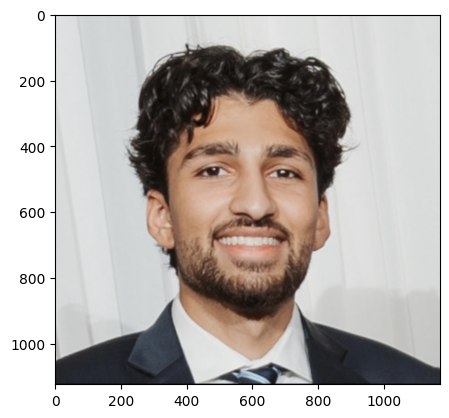

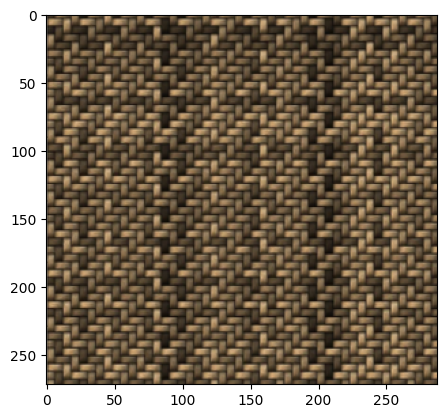

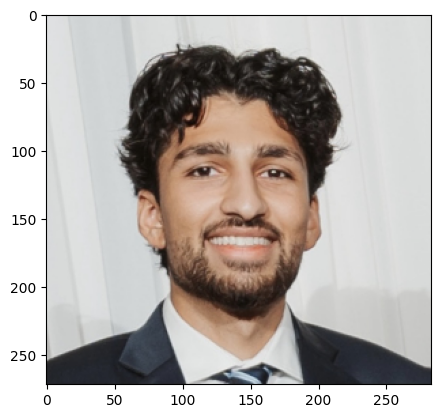

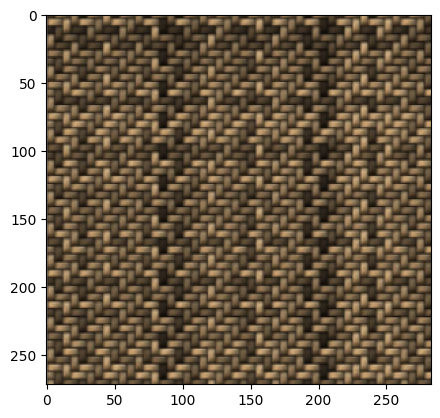

272
283
272
283
20
21
(272, 283, 3)


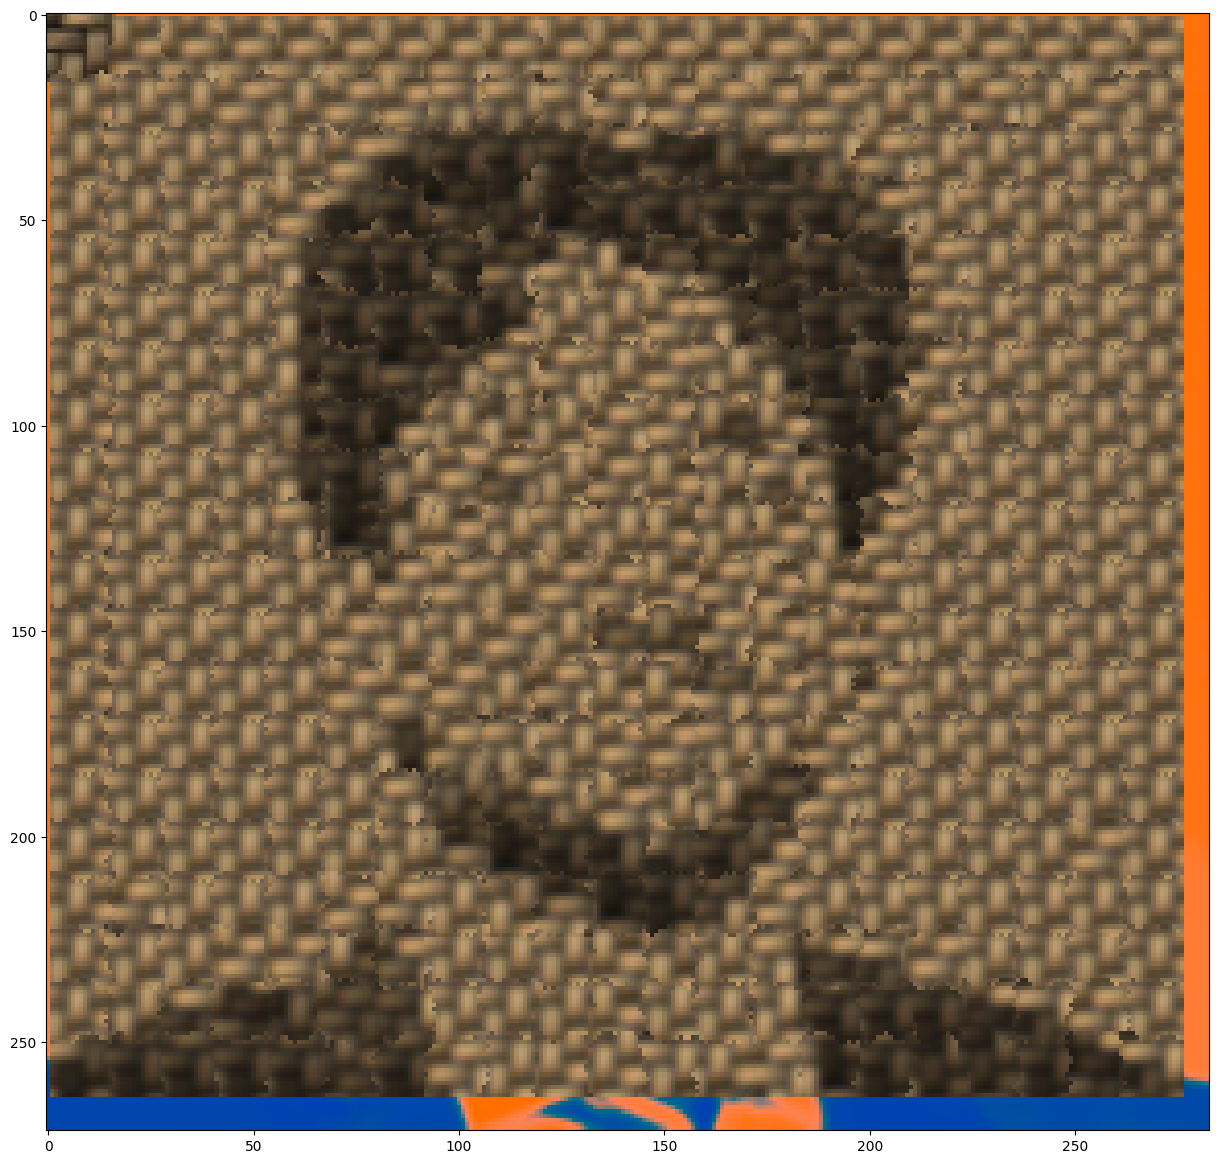

In [557]:
# load/process appropriate input texture and guidance images
guidance_img = datadir + 'Taha_Pic.jpeg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()


texture_img = datadir + 'basket_weave.png'
texture_img = cv2.cvtColor(cv2.imread(texture_img), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()



patch_size =17
overlap = 4
tol = 2
alpha = 0.3
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

In [559]:
# load/process appropriate input texture and guidance images
guidance_img = datadir + 'Loki_pic.jpeg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()


texture_img = datadir + 'Brown_rice.jpeg'
texture_img = cv2.cvtColor(cv2.imread(texture_img), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()



patch_size = 26
overlap = 3
tol = 2
alpha = 0.4
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

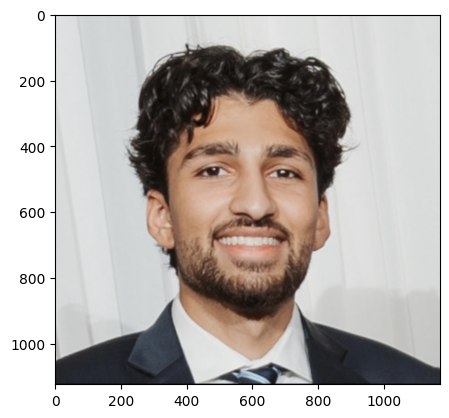

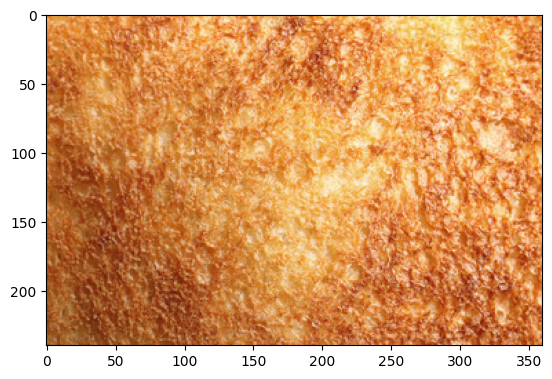

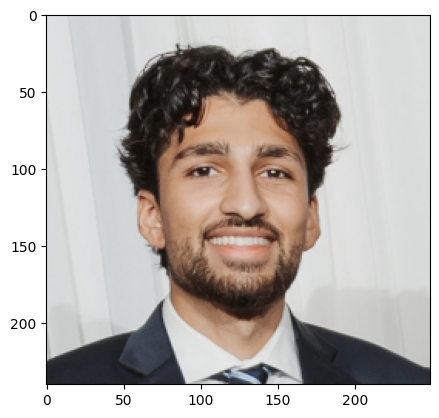

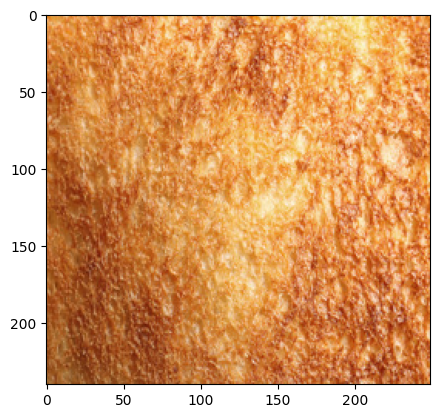

240
249
240
249
34
35
(240, 249, 3)


In [ ]:
# load/process appropriate input texture and guidance images
guidance_img = datadir + 'Taha_Pic.jpeg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()

texture_img = datadir + 'toast_texture.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img), cv2.COLOR_BGR2RGB)
plt.imshow(texture_img)
plt.show()


patch_size = 9
overlap = 2
tol = 2
alpha = 0.4
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

[242 214 141]


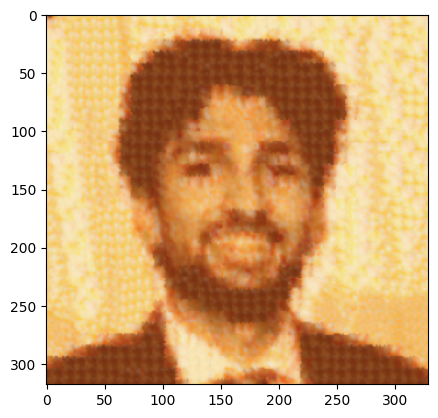

(557, 577, 3)


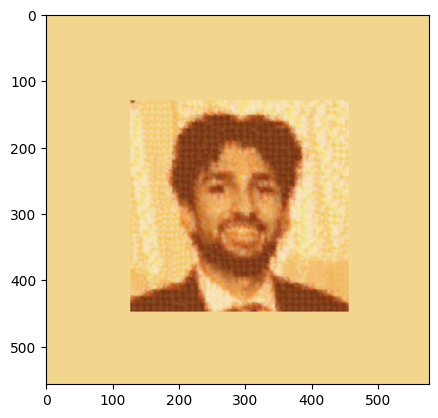

(213, 220, 3)


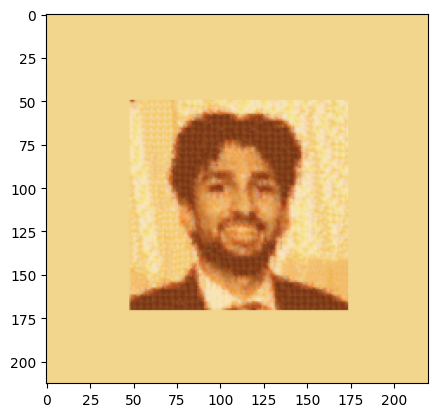

(213, 220, 3)


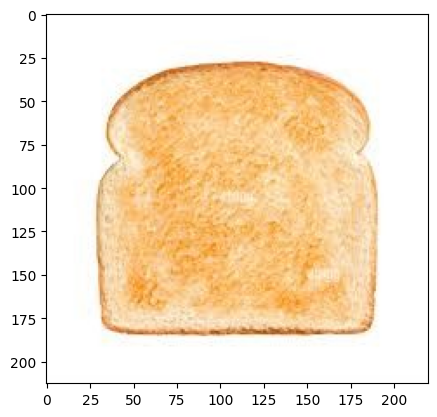

In [511]:
# load/process appropriate input texture and guidance images
face_img = datadir + 'toast_texture_face.png'
face_img = cv2.cvtColor(cv2.imread(face_img), cv2.COLOR_BGR2RGB)
rgb_value = face_img[5, 50]  # This gives an array [R, G, B]
print(rgb_value)

face_img = cv2.copyMakeBorder(face_img, 130, 109, 127, 121, cv2.BORDER_CONSTANT, value=[242, 214, 141])

face_img = cv2.resize(face_img, (220, 213))

print(face_img.shape)
plt.imshow(face_img)
plt.show()

toast_img = datadir + 'toast.jpg'
toast_img = cv2.cvtColor(cv2.imread(toast_img), cv2.COLOR_BGR2RGB)

print(toast_img.shape)
plt.imshow(toast_img)
plt.show()



# Alpha Compositing with Feathering

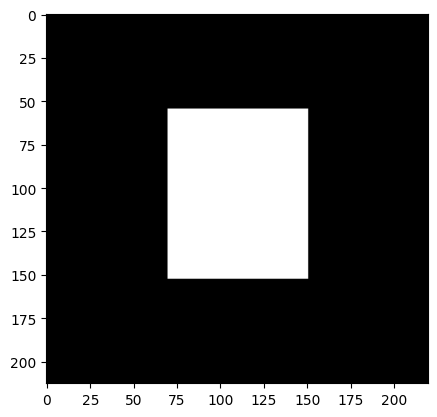

In [530]:
# Fill the inner region with white (255)
# Create a black mask (all zeros)
mask = np.zeros((213, 220), dtype=np.uint8)
mask[55:153, 70:151] = 255

plt.imshow(mask, cmap='gray')
# plt.axis("off")
plt.show()



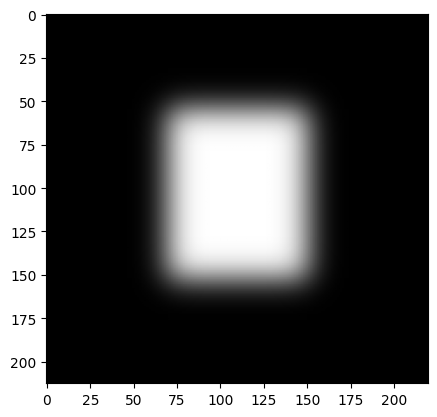

In [531]:
mask_blurred  = cv2.GaussianBlur(mask,(55,55),0)
mask_blurred_normalized = mask_blurred / 255.0
# Convert the single-channel blurred mask to 3-channel
mask_blurred = np.repeat(mask_blurred_normalized[:, :, np.newaxis], 3, axis=2)
plt.imshow(mask_blurred, cmap='gray')
# plt.axis("off")
plt.show()

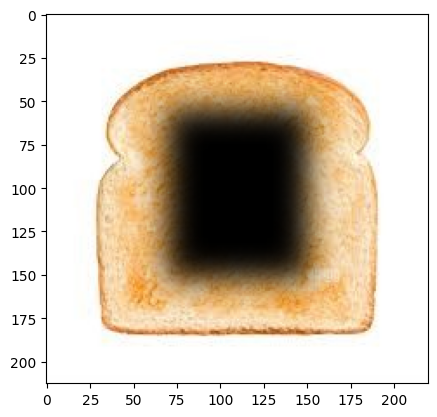

In [532]:
toast_img_masked = toast_img * (1-mask_blurred)
toast_img_masked = np.clip(toast_img_masked, 0, 255)
# Convert to uint8 for proper display in imshow
toast_img_masked = toast_img_masked.astype(np.uint8)
plt.imshow(toast_img_masked)
plt.show()

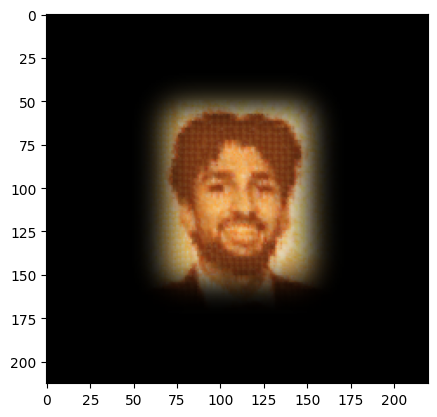

In [533]:
face_img_masked = face_img * mask_blurred
face_img_masked = np.clip(face_img_masked, 0, 255)
# Convert to uint8 for proper display in imshow
face_img_masked = face_img_masked.astype(np.uint8)
plt.imshow(face_img_masked)
plt.show()

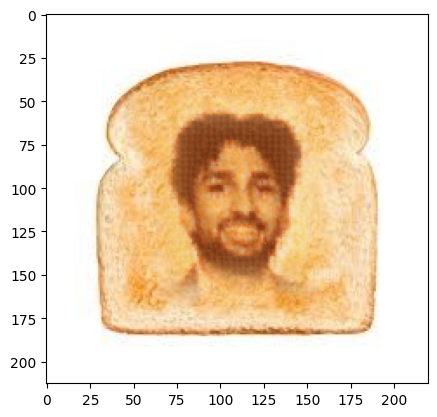

In [534]:
output = face_img_masked + toast_img_masked
plt.imshow(output)
plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).